# <center> RDS Project Draft Notebook</center>
    
### <center>By Ankush Jain (aj2885) and Vishnu Thakral (vvt223)</center>

In [19]:
#Importing all relevant libraries
import pandas as pd
import numpy as np
import json
import csv
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#Loading data
# identity_individual_annotations = pd.read_csv('data/identity_individual_annotations.csv')
# sample_submission = pd.read_csv('data/sample_submission.csv')
#test_file = pd.read_csv('data/test.csv')
train_data_copy = pd.read_csv('data/train.csv')
train_data = train_data_copy.copy()
# test_private_expanded = pd.read_csv('data/test_private_expanded.csv')
# test_public_expanded = pd.read_csv('data/test_public_expanded.csv')
# toxicity_individual_annotations = pd.read_csv('data/toxicity_individual_annotations.csv')

## Data Pre-Processing

In [3]:
#Getting the shape of the train dataset
train_data.shape

(1804874, 45)

In [4]:
#Removing irrelevant columns
train_data = train_data.drop(['severe_toxicity','obscene','identity_attack', 'insult', 'threat','sexual_explicit'],axis=1)
train_data.shape

(1804874, 39)

In [5]:
train_data.head(2)

,id,target,comment_text,asian,atheist,bisexual,black,buddhist,christian,female,...,parent_id,article_id,rating,funny,wow,sad,likes,disagree,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2006,rejected,0,0,0,0,0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2006,rejected,0,0,0,0,0,0,4


## Data Profiling

In [6]:
#replacing the categorical value into numberic
train_data.replace({"rating":{"rejected": 0, "approved": 1}}, inplace=True)
train_data.rating.dtype

dtype('int64')

In [7]:
#laoding the comment with max size
train_data.comment_text.max()

'🤣gotta love it!'

In [8]:
#store the length of each comment
lens = []
for i in list(train_data['comment_text']):
    lens.append(len(i))

In [9]:
#find the smallest sized comment (as size xero is not considered as a comment)
train_data.loc[lens.index(1),'comment_text']

'k'

In [10]:
#extracting the unique columns that can be used to map to the database
a =list(train_data.columns)
unique = []
for i in a:
    if train_data[i].is_unique:
        unique.append(i)
print('The possible key for the dataset are:',unique)

The possible key for the dataset are: ['id']


In [11]:
#Store information like mean, median, max frequency, count, maximum occuring words/values in the attribute 
with open('numeric.csv', 'w') as f, open('non_numeric.csv', 'w') as c:
    #f is for numeric and c for categorical/textual
    f.write("attribute,count,unique,max,min,mean,median,std_dev,max_f1,f1_count,max_f2,f2_count,max_f3,f3_count,max_f4,f4_count,max_f5,f5_count\n")
    c.write("Attribute,Count,Unique,Max,Min,Max_frequency\n")
    for i in a:
        if train_data[i].dtype !='O':
            #dict_col[i]
            f.write("%s,"%(i))
            f.write("%f,"%(train_data[i].isnull().sum())) # all null values 
            f.write("%f,"%(train_data[i].nunique())) #unique values
            f.write("%f,"%(train_data[i].max())) # max in the attribute
            f.write("%f,"%(train_data[i].min())) #min in the attribute
            f.write("%f,"%(train_data[i].mean())) #mean of the values that belong to the attribute
            f.write("%f,"%(train_data[i].median())) # median of the attribute
            f.write("%f,"%(train_data[i].std())) #std devition of values
            max_values = train_data[i].value_counts(ascending=False) # taking the highest 5 occuring values
            max_values = max_values.reset_index().head(5) 
            for j in range(max_values.shape[0]):
                f.write("%f,"%(max_values.loc[j,'index']))
                f.write("%f,"%(max_values.loc[j,i]))
            f.write("\n")
        else:
            c.write("%s,"%(i))
            c.write("%f,"%(train_data[i].isnull().sum()))
            c.write("%f,"%(train_data[i].nunique()))
            c.write("\n")

In [12]:
#removing values that are NaN from the social group attributes
df_test = train_data.copy()
#dropping attributes that are neither label/social_group or label
#df_test = df_test.drop(['created_date','publication_id','parent_id','article_id', 'rating', 'funny','wow','sad', 'likes', 'disagree', 'identity_annotator_count','toxicity_annotator_count'],axis=1)
columns = ['id', 'comment_text', 'target', 'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white',  'psychiatric_or_mental_illness']
df_test = df_test[columns]
col_list = list(df_test.columns)
col_list =col_list[3:]
for col in col_list:
    df_test = df_test[df_test[col].notnull()]
    #df_test = df_test[df_test['atheist'].notnull()]
    print(col,df_test[col].sum(),df_test.shape)

male 44032.25796984777 (405130, 12)
female 51723.05737755975 (405130, 12)
homosexual_gay_or_lesbian 10375.613491363378 (405130, 12)
christian 38595.950841561535 (405130, 12)
jewish 7236.672289150351 (405130, 12)
muslim 20037.556176699083 (405130, 12)
black 13933.484259646462 (405130, 12)
white 23072.31180173668 (405130, 12)
psychiatric_or_mental_illness 4895.233197204576 (405130, 12)


#### Input Attribute Profiling
The input attribute **comment_text** has zero empty values and it ranges from 1 to 8813 in length. The high range of input text and high variability of length must be handled well by the feature extraction technique and the machine learning model.

#### Output Attribute Profiling
The output attribute/label **toxicity** has zero empty value, two unique values (0:False or 1:True) and a True:False ratio of 0.08:0.92. Hence, 92\% of the training data is Non-Toxic (toxicity is false) and 8\% data is Toxic (toxicity is true).

#### Social Group Attribute Profiling (Auxiliary Attribs)
Social Group Attributes or the annotations will be used in validating the fairness of the model predictions. All the above metrics have been calculated for 405130 annotated data entries. The value for each social group attribute in the data set denotes the probability of the comment being toxic and offensive to the particular social group. The probability will range from 0.0 (not toxic) to 1.0 (extremely toxic).

## Distributions
To study the distribution of data across the various ranges of probability, we have divided the data into 5 buckets ranging from 0.0 to 1.0 at an interval of 0.2. We plot the frequency of data samples that fall in each probability range or bucket to observe the distribution of probabilities across the various social groups.

In [13]:
#creating bins for the social group attributes so that we can make analysis amongst them and with the label 
def create_binned(df,i):
    bins = [0.0,0.2,0.4,0.6,0.8,1.0]
    binned_data= pd.cut(df[i],bins) 
    df['_'+i] = binned_data
    return df
#acco.loc[account_raw['IfrsBalanceEUR'].isna(), 'LoanGBVBuckets'] = 'missing values'
df_test1 = df_test.copy()
relevant = columns[3:]
for i in relevant:
    df_test1 = create_binned(df_test1,i)

In [14]:
#creating bin data for the plots
bin_list = list(df_test1.columns)
buckets = [[],[],[],[],[]]
for i in bin_list[12:]:
    temp = df_test1.groupby(i).count()
    temp =temp.reset_index()
    present = temp['id'].to_list()
    for j in range(len(buckets)):
        buckets[j].append((i,present[j]))

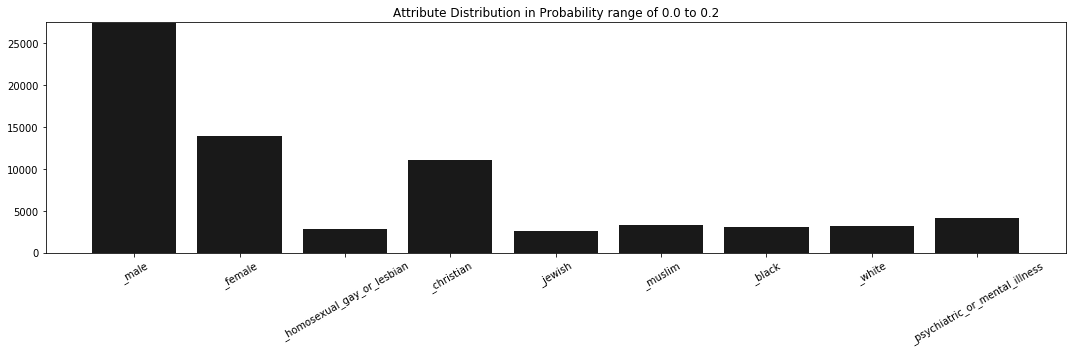

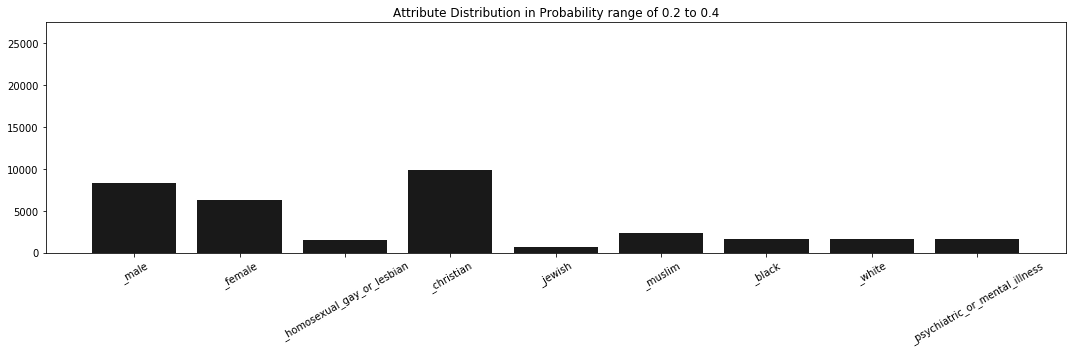

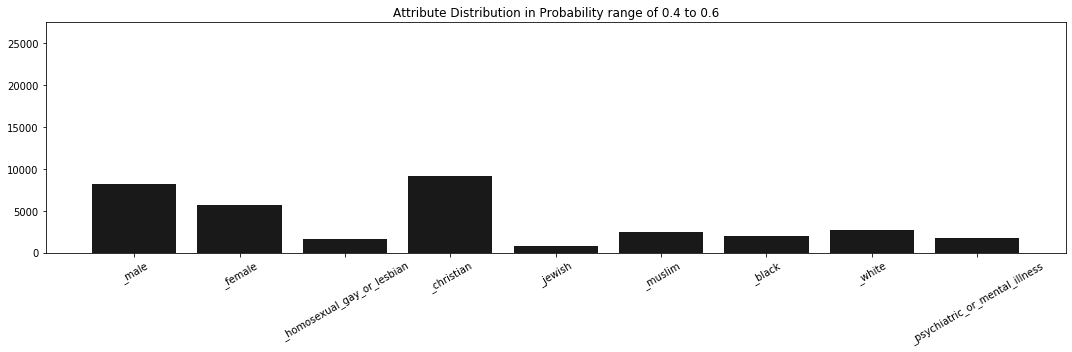

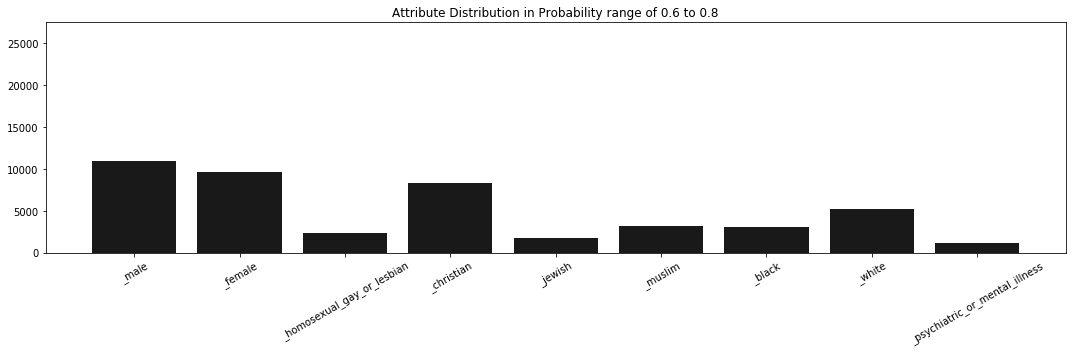

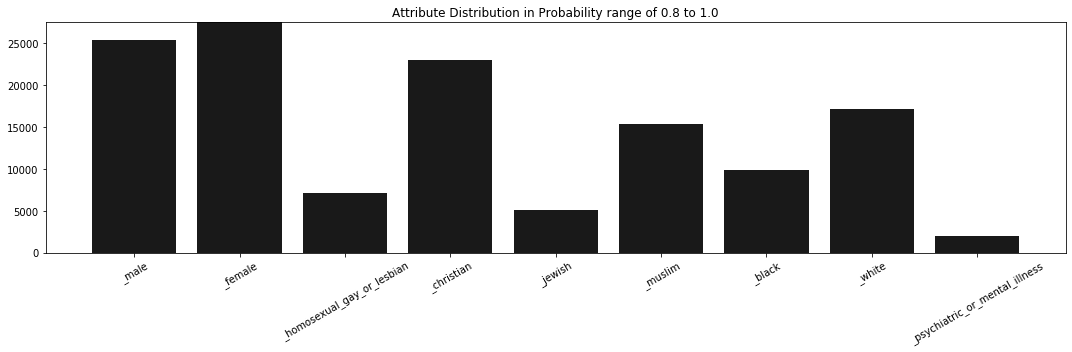

In [15]:
#plotting the distribution of values of various social group attributes in the 5 bins
def plotDistGraph(bucket, b_range):
    attrib = list(map(lambda x : x[0], bucket))
    y_pos = np.arange(len(attrib))
    counts = list(map(lambda x : x[1], bucket))
    plt.figure(figsize=(15, 5))
    plt.bar(y_pos, counts, align='center', alpha=0.9, color='black')
    plt.xticks(y_pos, attrib, rotation=30)
    plt.ylabel ='Frequency'
    plt.ylim(bottom=0, top=27500)
    plt.title('Attribute Distribution in Probability range of '+str(b_range[0])+' to '+str(b_range[1]))
    plt.tight_layout()
    
    plt.show()
    
plotDistGraph(buckets[0], [0.0, 0.2])
plotDistGraph(buckets[1], [0.2, 0.4])
plotDistGraph(buckets[2], [0.4, 0.6])
plotDistGraph(buckets[3], [0.6, 0.8])
plotDistGraph(buckets[4], [0.8, 1.0])

From the above distribution plots, it is evident that the social groups most impacted by toxicity are female, male, christian and muslim.  From the social group attribute profiling, it was evident that female and male groups had high means for probability of toxicity. These plots have validatedthe results.

## Correlations
We will calculate the pearson correlation which can range between -1 to 1 with -1 being negative correlation and 1 being a total positive correlation.



In [16]:
df_test.columns

Index(['id', 'comment_text', 'target', 'male', 'female',
       'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black',
       'white', 'psychiatric_or_mental_illness'],
      dtype='object')

In [43]:
#figuring out the correlation between various social group attributes and the target/label
def plot_corr(a,b):
    temp = df_test.columns[a:b].to_list()
    print(temp)
    return (df_test[temp].corr())

['target', 'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']


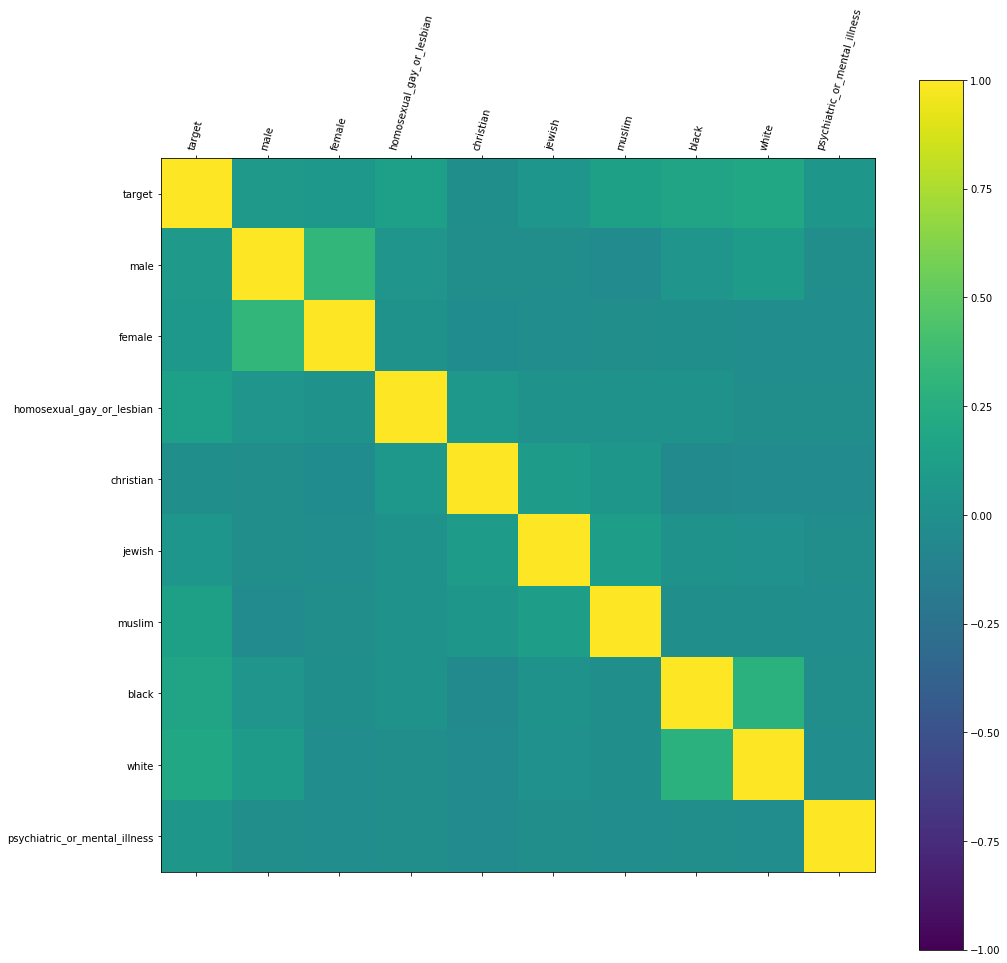

In [44]:
# plot correlation matrix
correlations = plot_corr(2,12)
names = df_test.columns[2:].to_list()
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,10,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names,rotation=75)
ax.set_yticklabels(names)
plt.savefig('correlation.png')
plt.show()


Target has a high correlation with Male category


There is a noticeable amount of linear correlation between 

1) muslim and target 

2) homosexual_gay_or_lesbian and target

3) psychiatric_or_mental_illness has less correlation than muslim and target and homosexual_gay_or_lesbian and target

4) Christian has negligible correlation with target